In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'
train_out_dir = '../../02_train/out/'

# data, primarily for the ice flags
train_data_fpath = process_out_dir + 'train_data.npz'
valid_data_fpath = process_out_dir + 'valid_data.npz'

train_predictions_fpath = train_out_dir + 'basic_lstm_train_preds.npy'
valid_predictions_fpath = train_out_dir + 'basic_lstm_valid_preds.npy'

### Values

In [3]:
# when deriving the max ice on date, one detail is that
# we must omit the late ice on dates that occur during a
# (predicted) rethaw. This value is a temporal index
# representing the maximum day after July 1 that can
# be a considered a max ice on date.
# A value of 215 equates to February 1
ice_on_cutoff = 215

n_days_hist_cutoff = 75

### Outputs

In [4]:
eval_metrics_fpath = '../out/eval_metrics.npz'

# Import data

In [5]:
# Import both development partitions
train_data = np.load(train_data_fpath, allow_pickle = True)
valid_data = np.load(valid_data_fpath, allow_pickle = True)

# Extract everything from training partition
train_x = train_data['x']
train_y = train_data['y']
train_dates = train_data['dates']
train_DOW = train_data['DOW']
train_variables = train_data['features']

# Extract everything from validation partition
valid_x = valid_data['x']
valid_y = valid_data['y']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW']
valid_variables = valid_data['features']

In [6]:
train_predictions = np.load(train_predictions_fpath)
valid_predictions = np.load(valid_predictions_fpath)

In [7]:
# Programmatically identify process-based ice flag data
ice_var_idx = int(np.argwhere(train_variables == 'ice'))
assert valid_variables[ice_var_idx] == 'ice'

# Convert predicted probabilities into predicted class (ice or not)

In [8]:
# View the validation set's min and max probability first
valid_predictions.min(), valid_predictions.max()

(0.0017262313, 0.99541134)

In [9]:
# Round probabilities
train_predictions_class = np.round(train_predictions)
valid_predictions_class = np.round(valid_predictions)

# Overall accuracy

Including quick check on overfitting

In [10]:
def calc_accuracy(pred_probs, obs):
    # Here, the 0-index is just getting rid of the feature
    # dimension of the (originally) pytorch prediction object
    flat_preds = pred_probs[:, :, 0].flatten()
    flat_obs = obs.flatten()
    
    return np.sum(flat_preds == flat_obs) / flat_obs.shape[0]
    

In [11]:
print('Model accuracy on training set:', calc_accuracy(train_predictions_class, train_y))
print('\nModel accuracy on validation set:', calc_accuracy(valid_predictions_class, valid_y))

Model accuracy on training set: 0.97743823010337

Model accuracy on validation set: 0.9762829687180535


### Compare to process-based ice flag input

In [12]:
assert train_variables[ice_var_idx] == valid_variables[ice_var_idx] == 'ice'

def calc_accuracy_iceflags(inputs, obs):
    
    flat_ice_flags = inputs[:, :, ice_var_idx].flatten()
    flat_obs = obs.flatten()
    
    return np.sum(flat_ice_flags == flat_obs) / flat_obs.shape[0]

In [13]:
print('Ice flag accuracy on training set:', calc_accuracy_iceflags(train_x, train_y))
print('\nIce flag accuracy on validation set:', calc_accuracy_iceflags(valid_x, valid_y))

Ice flag accuracy on training set: 0.9544793680141188

Ice flag accuracy on validation set: 0.9529433968199047


*NOTE* Ensure that training set and validation performance are very similar

# Error of predicted ice on/off dates

### Derive predicted max ice on and max ice off dates

In [14]:
ice_on = []
ice_off = []
pred_ice_on = []
pred_ice_off = []
flag_ice_on = []
flag_ice_off = []

for i in range(valid_y.shape[0]):
    # Result in +1 when ice emerges and -1 when ice disappears. 0 otherwise.
    valid_diff_y_i = np.diff(valid_y[i, :])
    valid_diff_y_hat_i = np.diff(valid_predictions_class[i, :, 0])
    valid_diff_flag_i = np.diff(valid_x[i, :, ice_var_idx])
    
    # Indexing by -1 finds the latest/"max" occurrence
    # for ice_on, we need to avoid late season refreeze ice on dates
    valid_ice_on_index = np.argwhere(valid_diff_y_i == 1)[np.argwhere(valid_diff_y_i == 1) < ice_on_cutoff][-1].item()
    valid_ice_off_index = np.argwhere(valid_diff_y_i == -1)[-1].item()
    valid_pred_ice_on_index = np.argwhere(valid_diff_y_hat_i == 1)[np.argwhere(valid_diff_y_hat_i == 1) < ice_on_cutoff][-1].item()
    valid_pred_ice_off_index = np.argwhere(valid_diff_y_hat_i == -1)[-1].item()
    valid_flag_ice_on_index = np.argwhere(valid_diff_flag_i == 1)[np.argwhere(valid_diff_flag_i == 1) < ice_on_cutoff][-1].item()
    valid_flag_ice_off_index = np.argwhere(valid_diff_flag_i == -1)[-1].item()
    
    # Store found dates
    ice_on.append(valid_dates[i, valid_ice_on_index])
    ice_off.append(valid_dates[i, valid_ice_off_index])
    pred_ice_on.append(valid_dates[i, valid_pred_ice_on_index])
    pred_ice_off.append(valid_dates[i, valid_pred_ice_off_index])
    flag_ice_on.append(valid_dates[i, valid_flag_ice_on_index])
    flag_ice_off.append(valid_dates[i, valid_flag_ice_off_index])

### Define some functions to deal with those dates

In [15]:
def calc_date_errors(iceflag_dates, pred_dates, obs_dates):
    # convert obj/str dates into datetimes
    formatted_iceflag_dates = np.asarray(iceflag_dates).astype(np.datetime64)
    formatted_pred_dates = np.asarray(pred_dates).astype(np.datetime64)
    formatted_obs_dates = np.asarray(obs_dates).astype(np.datetime64)
    
    # calc simple difference
    iceflag_errors = formatted_obs_dates - formatted_iceflag_dates
    pred_errors = formatted_obs_dates - formatted_pred_dates
    
    # convert datetime difference to int (days)
    iceflag_errors = iceflag_errors.astype(int)
    pred_errors = pred_errors.astype(int)
    
    return iceflag_errors, pred_errors

# simple RMSE calculation
def calc_rmse(errors):
    return np.sqrt(np.sum(errors**2) / len(errors))

def plot_and_print_date_errors(pb_model_errors, new_model_errors):
    # Plotting
    plt.figure(figsize = (8, 5))
    # histogram of process-based errors
    plt.hist(pb_model_errors, bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff),
             label = 'Ice flag', zorder = 0)
    # histogram of new model errors
    plt.hist(new_model_errors, bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff),
             label = 'Prediction', zorder = 1,
             histtype = 'step', linewidth = 2)
    # 0-line for reference
    plt.axvline(0, color = 'black', zorder = 2)
    plt.legend()

    # Print metrics for PB
    print('Average flag error: ', np.mean(pb_model_errors))
    print('Flag RMSE: ', calc_rmse(pb_model_errors))
    
    # Print metrics for new
    print('\nAverage pred error: ', np.mean(new_model_errors))
    print('Pred RMSE: ', calc_rmse(new_model_errors))

### Errors for `max_ice_on`

Average flag error:  8.045924225028703
Flag RMSE:  12.459993384108683

Average pred error:  -0.4890929965556831
Pred RMSE:  7.512102749248695


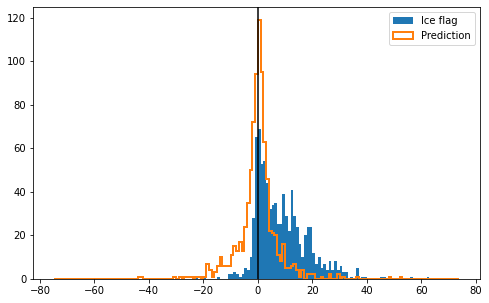

In [16]:
flag_error_ice_on, pred_error_ice_on = calc_date_errors(flag_ice_on, pred_ice_on, ice_on)

plot_and_print_date_errors(flag_error_ice_on, pred_error_ice_on)

### Errors for `max_ice_off`

Average flag error:  5.719862227324914
Flag RMSE:  10.106323400479825

Average pred error:  -0.4489092996555683
Pred RMSE:  5.926937474790869


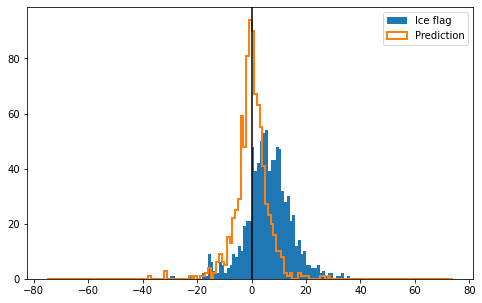

In [17]:
flag_error_ice_off, pred_error_ice_off = calc_date_errors(flag_ice_off, pred_ice_off, ice_off)

plot_and_print_date_errors(flag_error_ice_off, pred_error_ice_off)

# Error of predicted ice duration

In [18]:
# Simply take number of days between ice on and ice off for ice duration
def calc_ice_duration(off, on):
    dur = np.asarray(off).astype(np.datetime64) - np.asarray(on).astype(np.datetime64)
    return dur.astype(int)

In [19]:
# Convert dates to days between on and off
obs_dur = calc_ice_duration(ice_off, ice_on)
pred_dur = calc_ice_duration(pred_ice_off, pred_ice_on)
flag_dur = calc_ice_duration(flag_ice_off, flag_ice_on)

# Compare model outputs to observations
pred_error_dur = obs_dur - pred_dur
flag_error_dur = obs_dur - flag_dur

# Get the associated RMSE
print("Ice flag duration RMSE:", calc_rmse(flag_error_dur))
print("\nModel duration RMSE:", calc_rmse(pred_error_dur))

Ice flag duration RMSE: 13.309354634268027

Model duration RMSE: 9.46775299254786


# Save these calculcated errors

In [20]:
# Batch all these calculated errors together
evals = {'flag_error_ice_on':flag_error_ice_on,
         'flag_error_ice_off':flag_error_ice_off,
         'flag_error_dur':flag_error_dur,
         'pred_error_ice_on':pred_error_ice_on,
         'pred_error_ice_off':pred_error_ice_off,
         'pred_error_dur':pred_error_dur}

In [21]:
np.savez_compressed(eval_metrics_fpath, **evals)